In [3]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.signal import lfilter, butter, decimate, hann
import scipy.stats as stats
import datetime
from time import localtime, strftime
import warnings

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, Callback
from tensorflow.keras import Input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, Flatten, Activation, Lambda, Convolution1D, Dense, add

from UTILS import *
from wfdisc_utils import WFDISC

%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings("ignore",category=FutureWarning)
pd.set_option('display.max_columns', 500)

model_folder='models/'
log_folder='logs/'
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
if not os.path.exists(log_folder):
    os.mkdir(log_folder)

# DeepPick:

This Notebook details the development of a simple Picking algorithm for three-component Seismograms:


We will proceed in three parts:

1) Data Wrangling

2) Model Architecture

3) Training and Testing


# STEP 1: Data Wrangling

### Load Bulletin:


In [8]:
def read_cat(filename):
    cat = pd.read_csv(filename, index_col=0)
    cat['TIME'] = pd.to_datetime(cat['TIME'])
    cat.fillna('', inplace=True)
    cat = cat.sort_values(by=['TIME'])
    cat.reset_index(drop=True, inplace=True)
    return cat

In [9]:
cat = read_cat('data/IDCLEB_arrivals_arrays_13_15.csv')

In [10]:
print(list(cat.IPHASE.value_counts().index))

['P', 'LR', 'tx', 'Pn', 'N', 'Sx', 'PcP', 'Lg', 'Sn', 'S', 'PKP', 'Pg', 'ScP', 'pP', 'PP', 'Px', 'PKi', 'PKK', 'Rg', 'SKP', 'Pdi', 'ScS', 'P3K', 'pPK', 'PKh', 'sP', 'P4K', 'SKK', 'Sdi', 'SKi']


In [11]:
# Define Training Catalog
stations = ['ASAR', 'ILAR', 'MKAR', 'NVAR', 'PDAR', 'TXAR']
start_time = '2013-01-01'
end_time = '2014-01-01'
# Specify the phases you wish to train on
phases = ['P', 'Pn', 'Pc', 'PcP', 'PK', 'Pg', 'PKP', 'pP', 'PP', 'Px']

# Build Training Catalog
cat =  cat.loc[(cat.STA.isin(stations)) &                    
                (cat.TIME > start_time) & 
                (cat.TIME < end_time)  &
                (cat.IPHASE.isin(phases))
              ].reset_index(drop=True)

In [12]:
phase_type_dict = {}
phase_type_map = {}

# phase_type_dict['regional_P'] = ['Pn', 'Pg']
# phase_type_dict['teleseis_P'] = ['P', 'PKP', 'pP', 'I', 'sP', 'PKKPbc', 'PKP2', 'PP', 'PcP', 'SKPbc', 'PKiKP', 'pPKP', 'PKPbc', 'SKP', 'ScP', 'SKKPbc']
# phase_type_dict['secondary']  = ['Sn', 'S', 'ScS', 'Rg', 'I', 'LR']
# phase_type_dict['surface']    = ['Lg']
phase_type_dict['P'] = ['P', 'Pn', 'Pc', 'PcP', 'PK', 'Pg', 'PKP', 'pP', 'PP', 'Px']

# create the mapping dictionary:
for typ in phase_type_dict:
    phase_type_map.update({k:v for (k,v) in [(p, typ) for p in phase_type_dict[typ]]})
    
# create the new 'PHASE_TYPE' column and fill it with the assigned types:
cat['PHASE_TYPE'] = cat.IPHASE.map(phase_type_map)

# Check the class imbalance of the newly defined types:
cat.PHASE_TYPE.value_counts()

P    172429
Name: PHASE_TYPE, dtype: int64

We now save the catalog and display its contents.

In [13]:
def datetime2epoch(timestamp):
    return (timestamp - datetime.datetime(1970, 1, 1)).total_seconds()

def get_wav(sta, st_time, en_time, pdict, data_dir='data/css'):
    cmpts = pdict['cmpts']
    
    X = []
    date = st_time.strftime('%Y-%-m-%-d')
    day = f'{st_time.timetuple().tm_yday:03d}'
        
    file = os.path.join(data_dir, f'{date}/{sta}.{st_time.year}{day}.wfdisc')
    wf = WFDISC(file)

    if sta[-2:] == 'AR':
        sta = sta[:-2] + '31'
        
    for chan in ['BH' + l for l in cmpts]:
        X.append(wf.getData(sta, chan, datetime2epoch(st_time), datetime2epoch(en_time)))
    X = np.stack(X, axis=-1)
    
    if X.shape == (int(pdict['w_len'] * pdict['r_smp']), len(pdict['cmpts'])):
        return X
    else:
        raise Exception()

def DAT_normalize(X):
    X = X - np.expand_dims(np.mean(X,1),1)
    X = X / np.expand_dims(np.expand_dims(np.abs(X).max(1).max(1), 1), 1)
    return X

def butter_bandpass(lowcut, highcut, fs, order=8):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    return b, a

def DAT_filter(X, pdict, order=3):
    lowcut = pdict['f_low']
    highcut = pdict['f_hig']
    fs = pdict['r_smp']
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, X, axis=1) 

def DAT_taper(X, taper_percentage=.05):
    npts = X.shape[1]
    taper_len = int(npts * taper_percentage)
    taper_sides = hann(2 * taper_len + 1)
    taper = np.hstack((taper_sides[:taper_len], np.ones(npts - taper_len)))
    return X * np.reshape(taper,(1,-1,1))

In [14]:
pdict = {}
pdict['f_low'] = 1
pdict['f_hig'] = 4
pdict['r_smp'] = 40
pdict['cmpts'] = 'ZNE'
pdict['w_len'] = 60

arrival = cat.sample().iloc[0]
sta = arrival.STA
st = arrival.TIME - pd.Timedelta(pdict['w_len']/2, 's')
en = arrival.TIME + pd.Timedelta(pdict['w_len']/2, 's')

seis = get_wav(sta, st, en, pdict)

Exception: No Valid CSS Segments were read. Check your path.

In [15]:
plt.plot(DAT_filter(np.expand_dims(seis,0), pdict)[0,:,0])

NameError: name 'seis' is not defined

### Create Characteristic Function from catalog:

In [16]:
def get_c(c_width_in_samples, c_shape=None, c_amplitude=1, c_buffer_in_samples=0):

    if c_shape == 'gauss':
        x = stats.norm.pdf(np.linspace(-3, 3, c_width_in_samples))
        x = (x - x.min()) / (x - x.min()).max()
    else:
        x = np.ones(c_width_in_samples)

    return np.hstack([np.zeros(c_buffer_in_samples), x*c_amplitude])


def get_cFunc(indices, pdict):
    
    w_tot_samps = int(pdict['r_smp'] * pdict['w_len'])
    c_len_samps = int(pdict['r_smp'] * pdict['c_len'])
    c_buf_samps = int(pdict['r_smp'] * pdict['c_buf'])
    c_tot_samps = c_len_samps + c_buf_samps
    
    cFunc = np.zeros((w_tot_samps, 1))

    for idx in indices:
        c1 = cFunc[idx:idx + c_tot_samps, 0]
        c2 = get_c(c_len_samps, pdict['c_shp'], pdict['c_amp'], c_buf_samps)[:len(c1)]
        cFunc[idx:idx + c_tot_samps, 0] = np.maximum(c1, c2)
            
    return cFunc

In [17]:
depth = len(cat.PHASE_TYPE.unique())+1

arrival = cat.sample().iloc[0]
win_len = 30
sta = arrival.STA
st = arrival.TIME - pd.Timedelta(win_len/2, 's')
en = arrival.TIME + pd.Timedelta(win_len/2, 's')

my_cat = cat.loc[(cat.STA == sta) & (cat.TIME >= st) & (cat.TIME <= en)]
arr_idx = [int(np.floor((t - st).total_seconds() * pdict['r_smp'])) for t in my_cat.TIME]

pdict={}
pdict['w_len'] = 30
pdict['c_len'] = 1
pdict['c_buf'] = 0
pdict['c_shp'] = 'gauss'
pdict['c_amp'] = 1
pdict['f_low'] = 1
pdict['f_hig'] = 4
pdict['r_smp'] = 40
pdict['cmpts'] = 'ZNE'
pdict['task'] = 'c'
pdict['nb_cl'] = len(cat.PHASE_TYPE.unique())

seis = get_wav(sta, st, en, pdict)
cFunc = get_cFunc(arr_idx, pdict)

fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True)
_ = ax[0].plot(seis)
_ = ax[1].plot(cFunc)


Exception: No Valid CSS Segments were read. Check your path.

# STEP 2: Model Architecture

### Deep Temporal Convolutional Neural Network:


In [17]:
def RecFldLen(pdict):
    # Code to calculate the receptive field length of the neural network
    r = 0
    for d in pdict['d']:
        r = r + d * (pdict['k']-1)
    return f'{r/pdict["r_smp"]} seconds'

def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0):
    prev_x = x
    for k in range(2):
        x = Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding)(x)
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = add([prev_x, x])
    return res_x, x


def encoder_network(pdict, padding='causal', drop=0.05):
    
    nb_chan    = len([char for char in pdict['cmpts']])
    nb_filters = pdict['f']
    filter_len = pdict['k']
    dilations  = pdict['d']
    nb_stacks  = pdict['s']
    
    o_act = 'sigmoid'
    if pdict['c_shp'] == 'gauss':
        o_act = 'linear'
    
    input_layer = Input(shape=(None, nb_chan))

    x = input_layer

    skip_connections = []
    for s in range(nb_stacks):
        for d in dilations:
            x, skip_out = residual_block(x,
                                         dilation_rate=d,
                                         nb_filters=nb_filters,
                                         kernel_size=filter_len,
                                         padding=padding,
                                         dropout_rate=drop)
            skip_connections.append(skip_out)

    x = add(skip_connections)

    output_layer = Dense(1, activation=o_act, name='output')(x)

    return Model(input_layer, output_layer, name='encoder_model')

In [18]:
def load_custom_model(pdict, model_folder='models'):

    if 'iniW' in pdict.keys():
        model_name = [n for n in os.listdir(model_folder) if f'|time:{pdict["iniW"]}' in n][0]
        model_file = os.path.join(model_folder, model_name)

        print('loading previous model:\n', model_file)
        pdict = name2param(os.path.basename(model_file))
        model = load_model(model_file)
    else:
        model_name = param2name(pdict)
        model_file = os.path.join(model_folder, model_name)

        print('building new model:\n', model_file)
        model = encoder_network(pdict)

    loss = 'binary_crossentropy'
    if pdict['c_shp'] == 'gauss':
        loss = 'mse'
                      
    o = Adam(lr=pdict['lr'], clipnorm=1.)
                      
    model.compile(loss=loss, optimizer=o)
    print(f'Receptive Field Length: {RecFldLen(pdict)}')

    return model, model_name



def get_callbacks(model_name, model_folder, log_folder):
    pdict = name2param(os.path.basename(model_name))
    tensor_foldername = os.path.join(log_folder, model_name)
    model_filename = os.path.join(model_folder, model_name + '.h5')

    sv = ModelCheckpoint(filepath=model_filename, monitor='val_loss', save_best_only=True,
                         save_weights_only=False, mode='min')
    tbd = TensorBoard(log_dir=tensor_foldername)
    stp = EarlyStopping(monitor='val_loss', min_delta=0, patience=pdict['pat'],
                        verbose=0, mode='min', baseline=None)

    return [sv, tbd, stp]


def param2name(pdict):
    name = []
    for key in pdict.keys():
        if type(pdict[key]) is list:
            name.append(f'{key}:{"x".join(map(str, pdict[key]))}')
        else:
            name.append(f'{key}:{pdict[key]}')
    return '|'.join(name)


def name2param(name):
    regnumber = re.compile(r'^\d+(\.\d+)?$')
    pdict = dict([p.split(':') for p in name.split('|')])
    for key in pdict.keys():
        if regnumber.match(pdict[key]):
            try:
                pdict[key] = int(pdict[key])
            except:
                pdict[key] = float(pdict[key])
        else:
            if 'x' in pdict[key][:-1]:
                pdict[key] = list(map(int, pdict[key].split('x')))
            try:
                pdict[key] = float(pdict[key])
            except:
                pass
    return pdict

### Generator Function:

In [19]:
def gen(cat, pdict):
    bs = pdict['bs']
    w_len_samps = int(pdict['r_smp'] * pdict['w_len'])
    cat = cat.copy().loc[cat.SNR > pdict['w_snr']]
    nb_chans = len(pdict['cmpts'])
    
    while 1:
        X = np.zeros((bs, w_len_samps, nb_chans))
        Y = np.zeros((bs, w_len_samps, 1))
        
        batch_counter = 0

        while batch_counter < bs:
            
            try:

                rec = cat.sample().iloc[0]
                sta = rec.STA
                st = rec.TIME - pd.Timedelta(pdict['w_len'] / 2, 's')
                en = rec.TIME + pd.Timedelta(pdict['w_len'] / 2, 's')
                trace = get_wav(sta, st, en, pdict)
                
                my_cat = cat.loc[(cat.STA == sta) & (cat.TIME >= st) & (cat.TIME <= en)]
                arr_idx = [int(np.floor((t - st).total_seconds() * pdict['r_smp'])) for t in my_cat.TIME]
                cFunc = get_cFunc(arr_idx, pdict)

                X[batch_counter], Y[batch_counter] = trace, cFunc
                batch_counter += 1
            except:
                pass
        
        if not pdict['c_shp'] == 'gauss':
            Y = Y > 0

        X = DAT_normalize(DAT_taper(DAT_filter(X, pdict)))
        yield X, Y
        

In [20]:
pdict={}
pdict['bs']    = 20
pdict['w_len'] = 300
pdict['c_len'] = 2
pdict['c_buf'] = 0
pdict['w_snr'] = 40
pdict['c_shp'] = 'gauss'
pdict['c_amp'] = 1
pdict['f_low'] = 1
pdict['f_hig'] = 4
pdict['r_smp'] = 40
pdict['cmpts'] = 'ZNE'

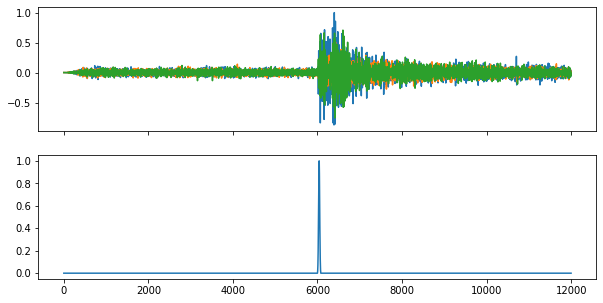

In [21]:
my_gen = gen(cat, pdict)
XX, YY = next(my_gen)

idx = np.random.randint(pdict['bs'])
fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True)
_ = ax[0].plot(XX[idx])
_ = ax[1].plot(YY[idx])

# STEP 3: Train and Test

### Partition Data:

We now split the dataset into three partitions: Train, Validation and Test

In [22]:
cat_trn = cat.loc[cat.TIME <= '2013-11-01']
cat_val = cat.loc[(cat.TIME > '2013-11-01') & (cat.TIME <= '2013-12-01')]
cat_tst = cat.loc[cat.TIME > '2013-12-01']

In [23]:
for name, my_cat in [('Training Set', cat_trn), ('Validation Set', cat_val), ('Test Set', cat_tst)]:
 
    print(name,'\n----------------------')
    print('START TIME:', my_cat.TIME.min())
    print('  END TIME:', my_cat.TIME.max())
    print('# STATIONS:', len(my_cat.STA.unique()))
    for phs in cat.PHASE_TYPE.unique():
        print(f'# ARIV ({phs}):', len(my_cat.loc[my_cat.PHASE_TYPE == phs]))
    print('\n')

Training Set 
----------------------
START TIME: 2013-01-01 00:00:22.250000
  END TIME: 2013-10-31 23:59:49.591500
# STATIONS: 6
# ARIV (P): 145777


Validation Set 
----------------------
START TIME: 2013-11-01 00:01:07.200000
  END TIME: 2013-11-30 23:54:11.150000
# STATIONS: 6
# ARIV (P): 13132


Test Set 
----------------------
START TIME: 2013-12-01 00:08:10.875000
  END TIME: 2013-12-31 23:59:42.930950
# STATIONS: 6
# ARIV (P): 13520




### Train the Model:

basic training

In [31]:
pdict = {}

# define parameters of the TCN architecture
pdict['f']     = 45
pdict['k']     = 15
pdict['d']     = [1, 2, 4, 8, 16]
pdict['s']     = 2

# define parameters of the data
pdict['bs']    = 20
pdict['w_snr'] = 10
pdict['w_len'] = 3*60
pdict['cmpts'] = 'ZNE'

# define parameters of preprocessing
pdict['r_smp'] = 40
pdict['f_low'] = 1
pdict['f_hig'] = 10
pdict['c_len'] = 2
pdict['c_buf'] = 10
pdict['c_shp'] = 'gauss'
pdict['c_amp'] = 1


# define parameters for training
pdict['lr']    = 0.0001
pdict['pat']   = 10
t_step = 100
v_step = 10

# load the model
model, model_name = load_custom_model(pdict)
model.summary()

# build the generators
gen_trn = gen(cat_trn, pdict)
gen_val = gen(cat_val, pdict)

# TRAIN!
my_hist = model.fit_generator(gen_trn, steps_per_epoch=t_step, epochs=5000,
                                  validation_data=gen_val, validation_steps=v_step,
                                  use_multiprocessing=True,
                                  callbacks=get_callbacks(model_name, model_folder, log_folder),
                                  workers = 8,
                                  max_queue_size=10)

building new model:
 models/f:45|k:15|d:1x2x4x8x16|s:2|bs:20|c_len:2|w_snr:10|c_buf:10|c_shp:gauss|c_amp:1|f_low:1|f_hig:10|r_smp:40|cmpts:ZNE|lr:0.0001|pat:10|w_len:180
Receptive Field Length: 10.85 seconds
Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
conv1d_240 (Conv1D)             (None, None, 45)     2070        input_9[0][0]                    
__________________________________________________________________________________________________
activation_160 (Activation)     (None, None, 45)     0           conv1d_240[0][0]                 
____________________________________________________________________________

Epoch 1/5000
100/100 [==============================] - 26s 264ms/step - loss: 0.0085 - val_loss: 0.0044
Epoch 2/5000
100/100 [==============================] - 26s 262ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 3/5000
100/100 [==============================] - 26s 260ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 4/5000
100/100 [==============================] - 26s 259ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 5/5000
100/100 [==============================] - 26s 260ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 6/5000
100/100 [==============================] - 26s 261ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 7/5000
100/100 [==============================] - 26s 261ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 8/5000
100/100 [==============================] - 26s 258ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 9/5000
100/100 [==============================] - 26s 259ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 10/5000
100/100 [==============================] 

Epoch 25/5000
100/100 [==============================] - 27s 268ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 26/5000
100/100 [==============================] - 26s 259ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 27/5000
100/100 [==============================] - 26s 261ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 28/5000
100/100 [==============================] - 26s 260ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 29/5000
100/100 [==============================] - 26s 262ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 30/5000
100/100 [==============================] - 26s 263ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 31/5000
100/100 [==============================] - 26s 259ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 32/5000
100/100 [==============================] - 27s 266ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 33/5000
100/100 [==============================] - 27s 267ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 34/5000
100/100 [=======================

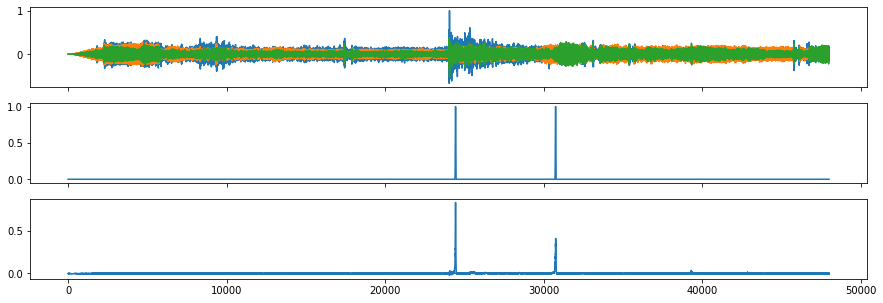

In [32]:
    pdict['w_len'] = 20*60
    gen_tst = gen(cat_tst, pdict)
    XX, YY = next(gen_tst)
    ZZ = model.predict(XX)
    
    idx = np.random.randint(pdict['bs'])
    fig, ax = plt.subplots(3, 1, figsize=(15,5), sharex=True)
    _ = ax[0].plot(XX[idx])
    _ = ax[1].plot(YY[idx])
    _ = ax[2].plot(ZZ[idx])

progressive training with increasingly noisy arrivals

In [24]:
pdict = {}
pdict['f']     = 45
pdict['k']     = 15
pdict['d']     = [1, 2, 4, 8, 16]
pdict['s']     = 2

pdict['bs']    = 20
pdict['c_len'] = 2
pdict['w_snr'] = 10
pdict['c_buf'] = 10
pdict['c_shp'] = 'gauss'
pdict['c_amp'] = 1
pdict['f_low'] = 1
pdict['f_hig'] = 10
pdict['r_smp'] = 40
pdict['cmpts'] = 'ZNE'

pdict['lr']    = 0.0001
pdict['pat']   = 3


t_step = 100
v_step = 10

pdict['pat'] = 0
pdict['lr']    = 0.0001

my_weights = None
# my_weights = model.get_weights()

for snr in [10, 8, 5, 3, 2, 1, 0]:
    
    # instatiate a new model with progressive snr, patience and learning rates
    my_time = strftime("%y-%m-%d-%H-%M-%S", localtime())
    pdict['time']  = my_time
    
    pdict['w_snr'] = snr
    pdict['pat']   += 3
    pdict['lr'] /= 3

    pdict['w_len'] = 5*60
    gen_val = gen(cat_val, pdict)
    
    pdict['w_len'] = 3*60
    gen_trn = gen(cat_trn, pdict)

    model, model_name = load_custom_model(pdict)
    model.summary()
    
    # Load weights from previous model
    if my_weights is not None:
        model.set_weights(my_weights)
    
    # Train new model instance
    my_hist = model.fit_generator(gen_trn, steps_per_epoch=t_step, epochs=50,
                                      validation_data=gen_val, validation_steps=v_step,
                                      use_multiprocessing=True,
                                      callbacks=get_callbacks(model_name, model_folder, log_folder),
                                      workers = 8,
                                      max_queue_size=10)
    
    # Load best model from previous training
    pdict = {}
    pdict['iniW'] = my_time
    model, model_name = load_custom_model(pdict)
    pdict = name2param(model_name)
    
    # Visualize performance of model
    XX, YY = next(gen_val)
    ZZ = model.predict(XX)
    
    idx = np.random.randint(pdict['bs'])
    fig, ax = plt.subplots(3, 1, figsize=(15,5), sharex=True)
    _ = ax[0].plot(XX[idx])
    _ = ax[1].plot(YY[idx])
    _ = ax[2].plot(ZZ[idx])
    plt.savefig(f'snr{snr}.jpg')
    plt.clf()
    
    # Store weights for next iteration of training
    my_weights = model.get_weights()

building new model:
 models/f:45|k:15|d:1x2x4x8x16|s:2|bs:20|c_len:2|w_snr:10|c_buf:10|c_shp:gauss|c_amp:1|f_low:1|f_hig:10|r_smp:40|cmpts:ZNE|lr:3.3333333333333335e-05|pat:3|time:20-06-25-21-58-25|w_len:180
Receptive Field Length: 10.85 seconds
Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 45)     2070        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, None, 45)     0           conv1d[0][0]                     
______________________________________

Epoch 1/50
100/100 [==============================] - 28s 281ms/step - loss: 0.0440 - val_loss: 0.0128
Epoch 2/50
100/100 [==============================] - 25s 253ms/step - loss: 0.0115 - val_loss: 0.0092
Epoch 3/50
100/100 [==============================] - 25s 252ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 4/50
100/100 [==============================] - 26s 257ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 5/50
100/100 [==============================] - 25s 252ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 6/50
100/100 [==============================] - 26s 260ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 7/50
100/100 [==============================] - 25s 253ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 8/50
100/100 [==============================] - 25s 255ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 9/50
100/100 [==============================] - 26s 258ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 10/50
100/100 [==============================] - 26s 256ms/step - l

100/100 [==============================] - 25s 245ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 50/50
100/100 [==============================] - 25s 250ms/step - loss: 0.0024 - val_loss: 0.0024
loading previous model:
 models/f:45|k:15|d:1x2x4x8x16|s:2|bs:20|c_len:2|w_snr:10|c_buf:10|c_shp:gauss|c_amp:1|f_low:1|f_hig:10|r_smp:40|cmpts:ZNE|lr:3.3333333333333335e-05|pat:3|time:20-06-25-21-58-25|w_len:180.h5
Receptive Field Length: 10.85 seconds
building new model:
 models/f:45|k:15|d:1x2x4x8x16|s:2|bs:20|c_len:2|w_snr:8|c_buf:10|c_shp:gauss|c_amp:1|f_low:1|f_hig:10|r_smp:40|cmpts:ZNE|lr:1.1111111111111112e-05|pat:6|time:20-06-25-22-19-32|w_len:180
Receptive Field Length: 10.85 seconds
Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 3)]    0                               

Epoch 1/50
100/100 [==============================] - 26s 255ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 2/50
100/100 [==============================] - 25s 250ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 3/50
100/100 [==============================] - 25s 252ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 4/50
100/100 [==============================] - 25s 251ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/50
100/100 [==============================] - 25s 249ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 6/50
100/100 [==============================] - 25s 250ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/50
100/100 [==============================] - 25s 253ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 8/50
100/100 [==============================] - 25s 252ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 9/50
100/100 [==============================] - 25s 250ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 10/50
100/100 [==============================] - 25s 250ms/step - l

Epoch 1/50
100/100 [==============================] - 26s 256ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 2/50
100/100 [==============================] - 25s 249ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 3/50
100/100 [==============================] - 25s 249ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 4/50
100/100 [==============================] - 25s 249ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 5/50
100/100 [==============================] - 25s 251ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/50
100/100 [==============================] - 25s 248ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 7/50
100/100 [==============================] - 25s 250ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 8/50
100/100 [==============================] - 25s 249ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 9/50
100/100 [==============================] - 25s 250ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 10/50
100/100 [==============================] - 25s 250ms/step - l

Epoch 1/50
100/100 [==============================] - 26s 258ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 2/50
100/100 [==============================] - 25s 247ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 3/50
100/100 [==============================] - 25s 250ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 4/50
100/100 [==============================] - 25s 250ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/50
100/100 [==============================] - 25s 255ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/50
100/100 [==============================] - 25s 252ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/50
100/100 [==============================] - 25s 253ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/50
100/100 [==============================] - 25s 250ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/50
100/100 [==============================] - 25s 254ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 10/50
100/100 [==============================] - 25s 252ms/step - l

Epoch 1/50
100/100 [==============================] - 26s 261ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 2/50
100/100 [==============================] - 25s 255ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 3/50
100/100 [==============================] - 26s 257ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 4/50
100/100 [==============================] - 25s 251ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/50
100/100 [==============================] - 25s 252ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/50
100/100 [==============================] - 25s 254ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/50
100/100 [==============================] - 25s 254ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/50
100/100 [==============================] - 25s 255ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 9/50
100/100 [==============================] - 25s 249ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/50
100/100 [==============================] - 25s 254ms/step - l

100/100 [==============================] - 26s 255ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 50/50
100/100 [==============================] - 26s 255ms/step - loss: 0.0029 - val_loss: 0.0031
loading previous model:
 models/f:45|k:15|d:1x2x4x8x16|s:2|bs:20|c_len:2|w_snr:2|c_buf:10|c_shp:gauss|c_amp:1|f_low:1|f_hig:10|r_smp:40|cmpts:ZNE|lr:4.11522633744856e-07|pat:15|time:20-06-25-22-51-52|w_len:180.h5
Receptive Field Length: 10.85 seconds
building new model:
 models/f:45|k:15|d:1x2x4x8x16|s:2|bs:20|c_len:2|w_snr:1|c_buf:10|c_shp:gauss|c_amp:1|f_low:1|f_hig:10|r_smp:40|cmpts:ZNE|lr:1.3717421124828532e-07|pat:18|time:20-06-25-23-13-18|w_len:180
Receptive Field Length: 10.85 seconds
Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, 3)]    0                                

Epoch 1/50
100/100 [==============================] - 26s 260ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 2/50
100/100 [==============================] - 26s 257ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 3/50
100/100 [==============================] - 25s 255ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 4/50
100/100 [==============================] - 26s 256ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 5/50
100/100 [==============================] - 25s 255ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 6/50
100/100 [==============================] - 26s 256ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 7/50
100/100 [==============================] - 25s 253ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 8/50
100/100 [==============================] - 25s 252ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 9/50
100/100 [==============================] - 26s 255ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 10/50
100/100 [==============================] - 26s 255ms/step - l

Epoch 1/50
100/100 [==============================] - 26s 263ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 2/50
100/100 [==============================] - 26s 258ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/50
100/100 [==============================] - 26s 260ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 4/50
100/100 [==============================] - 26s 258ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/50
100/100 [==============================] - 26s 260ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/50
100/100 [==============================] - 26s 259ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/50
100/100 [==============================] - 26s 258ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/50
100/100 [==============================] - 26s 259ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/50
100/100 [==============================] - 26s 260ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/50
100/100 [==============================] - 26s 260ms/step - l

100/100 [==============================] - 26s 260ms/step - loss: 0.0031 - val_loss: 0.0029
loading previous model:
 models/f:45|k:15|d:1x2x4x8x16|s:2|bs:20|c_len:2|w_snr:0|c_buf:10|c_shp:gauss|c_amp:1|f_low:1|f_hig:10|r_smp:40|cmpts:ZNE|lr:4.5724737082761776e-08|pat:21|time:20-06-25-23-27-43|w_len:180.h5
Receptive Field Length: 10.85 seconds


<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

### Visualize Results:

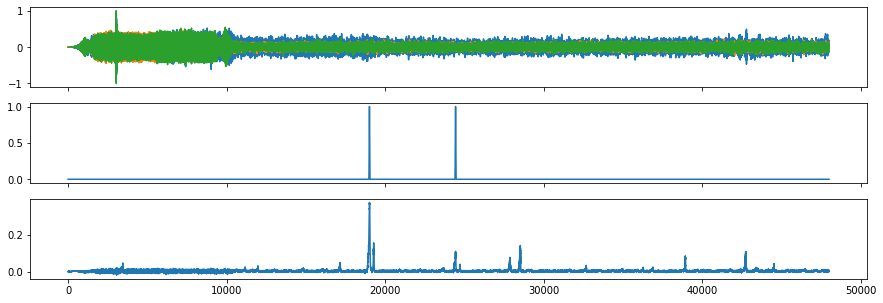

In [29]:
    pdict['w_len'] = 20*60
    gen_tst = gen(cat_tst, pdict)
    XX, YY = next(gen_tst)
    ZZ = model.predict(XX)
    
    idx = np.random.randint(pdict['bs'])
    fig, ax = plt.subplots(3, 1, figsize=(15,5), sharex=True)
    _ = ax[0].plot(XX[idx])
    _ = ax[1].plot(YY[idx])
    _ = ax[2].plot(ZZ[idx])